In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split

# 0. Prepare data

In [3]:
!gdown 1rDIj2ZToFvWHeENm4n3c__nCjOrEGWZN

Downloading...
From: https://drive.google.com/uc?id=1rDIj2ZToFvWHeENm4n3c__nCjOrEGWZN
To: /content/ptbdb_normal.csv
100% 19.0M/19.0M [00:00<00:00, 48.0MB/s]


In [4]:
!gdown 1oWjm4U04RKktAUUmdCqQM3YdHiiiDFKn

Downloading...
From: https://drive.google.com/uc?id=1oWjm4U04RKktAUUmdCqQM3YdHiiiDFKn
To: /content/ptbdb_abnormal.csv
100% 49.4M/49.4M [00:01<00:00, 39.6MB/s]


# 1. Load data

In [5]:
ecg_abnormal_dataframe = pd.read_csv("ptbdb_abnormal.csv", header=None)
ecg_normal_dataframe = pd.read_csv("ptbdb_normal.csv", header=None)

In [6]:
# Concat two dataframe
ecg_total_dataframe = pd.concat([ecg_normal_dataframe, ecg_abnormal_dataframe])
ecg_total_dataframe.columns = ecg_total_dataframe.columns.astype("str")
ecg_total_dataframe["187"] = ecg_total_dataframe["187"].astype("int64")
ecg_total_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


# 2. EDA

In [8]:
# ecg_total_dataframe.info(verbose=True, show_counts=True)

In [9]:
ecg_total_dataframe["187"].value_counts().sort_index()

0     4046
1    10506
Name: 187, dtype: int64

# 3. Preprocessing data

In [10]:
labels = {0: "Normal", 1: "Myocardial Infarction"}
print(labels)

{0: 'Normal', 1: 'Myocardial Infarction'}


ToDo: Oversampling

# 4. Train / Test Split

In [11]:
X = ecg_total_dataframe.loc[:, ecg_total_dataframe.columns != "187"].to_numpy()
y = ecg_total_dataframe.loc[:, "187"].to_numpy()

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [14]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(X_test.shape[0] / X_train.shape[0])

(11641, 187)
(2911, 187)
(11641,)
(2911,)
0.25006442745468604


# 5. Create model

In [19]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv1D, Dropout, Flatten, MaxPooling1D, AveragePooling1D, ReLU, Softmax, GlobalAveragePooling1D, Add
# from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.regularizers import L2
from tensorflow.keras.utils import plot_model

## 5.1. ANN model

In [20]:
def create_simple_ANN_model():
    input_layer = Input(shape = (187))

    dense_1 = Dense(64, activation=ReLU(), kernel_regularizer = L2()) (input_layer)
    dense_2 = Dense(32, activation=ReLU(), kernel_regularizer = L2()) (dense_1)
    output_layer = Dense(1, activation="sigmoid", kernel_regularizer = L2()) (dense_2)

    return Model(inputs=input_layer, outputs=output_layer)

simple_ann_model = create_simple_ANN_model()
simple_ann_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 187)]             0         
                                                                 
 dense (Dense)               (None, 64)                12032     
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 14145 (55.25 KB)
Trainable params: 14145 (55.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


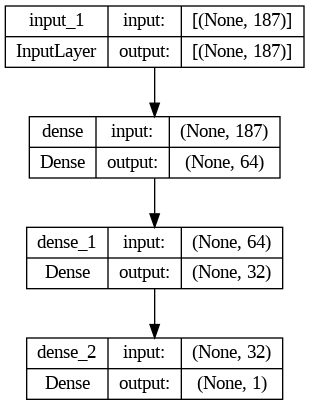

In [21]:
plot_model(simple_ann_model, show_shapes=True, show_layer_names=True)

In [23]:
simple_ANN_model = create_simple_ANN_model()
simple_ANN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

# simple_ANN_history = simple_ANN_model.fit(x=X_train, y=y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)

In [24]:
# TODO: Plot training process

In [25]:
# simple_ANN_model.save('simple_ANN_model')

## 5.2. CNN

In [26]:
def create_simple_CNN_model():
    input_layer = Input(shape = (187,1))

    conv_1 = Conv1D(filters=32, kernel_size = 3, strides = 1, padding="same") (input_layer)
    relu_1 = ReLU() (conv_1)
    maxpool_1 = MaxPooling1D(pool_size=2, strides=None, padding='valid') (relu_1)

    flatten = Flatten() (maxpool_1)
    dense_1 = Dense(64, activation=ReLU(), kernel_regularizer = L2()) (flatten)
    output_layer = Dense(1, activation="sigmoid", kernel_regularizer = L2()) (dense_1)
    return Model(inputs=input_layer, outputs=output_layer)

simple_cnn_model = create_simple_CNN_model()
simple_cnn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 187, 32)           128       
                                                                 
 re_lu_6 (ReLU)              (None, 187, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 93, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2976)              0         
                                                                 
 dense_9 (Dense)             (None, 64)                190528    
                                                           

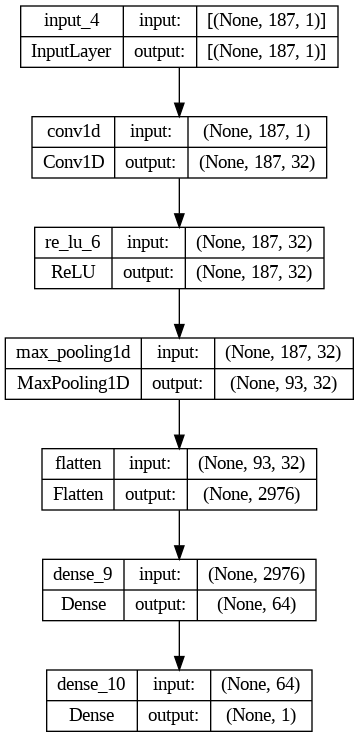

In [27]:
plot_model(simple_cnn_model, show_shapes=True, show_layer_names=True)

In [28]:
simple_CNN_model = create_simple_CNN_model()
simple_CNN_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)
# simple_CNN_history = simple_CNN_model.fit(x=X_train, y=y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)

In [29]:
# TODO: Plot training process

In [30]:
# simple_CNN_model.save('simple_CNN_model')

## 5.3. VGG16

In [31]:
def create_vgg16_model():
    # input
    input_layer = Input(shape =(187,1))

    # 1st Conv Block
    x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(input_layer)
    x = Conv1D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPooling1D(pool_size =2, strides =2, padding ='same')(x)

    # 2nd Conv Block
    x = Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPooling1D(pool_size =2, strides =2, padding ='same')(x)

    # 3rd Conv block
    x = Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPooling1D(pool_size =2, strides =2, padding ='same')(x)

    # 4th Conv block
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPooling1D(pool_size =2, strides =2, padding ='same')(x)

    # 5th Conv block
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = Conv1D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
    x = MaxPooling1D(pool_size =2, strides =2, padding ='same')(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(units = 4096, activation ='relu')(x)
    x = Dense(units = 4096, activation ='relu')(x)
    output_layer = Dense(units = 1, activation ='softmax')(x)

    return Model(inputs=input_layer, outputs=output_layer)


vgg16_model = create_vgg16_model()
vgg16_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 187, 64)           256       
                                                                 
 conv1d_3 (Conv1D)           (None, 187, 64)           12352     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 94, 64)            0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 94, 128)           24704     
                                                                 
 conv1d_5 (Conv1D)           (None, 94, 128)           49280     
                                                           

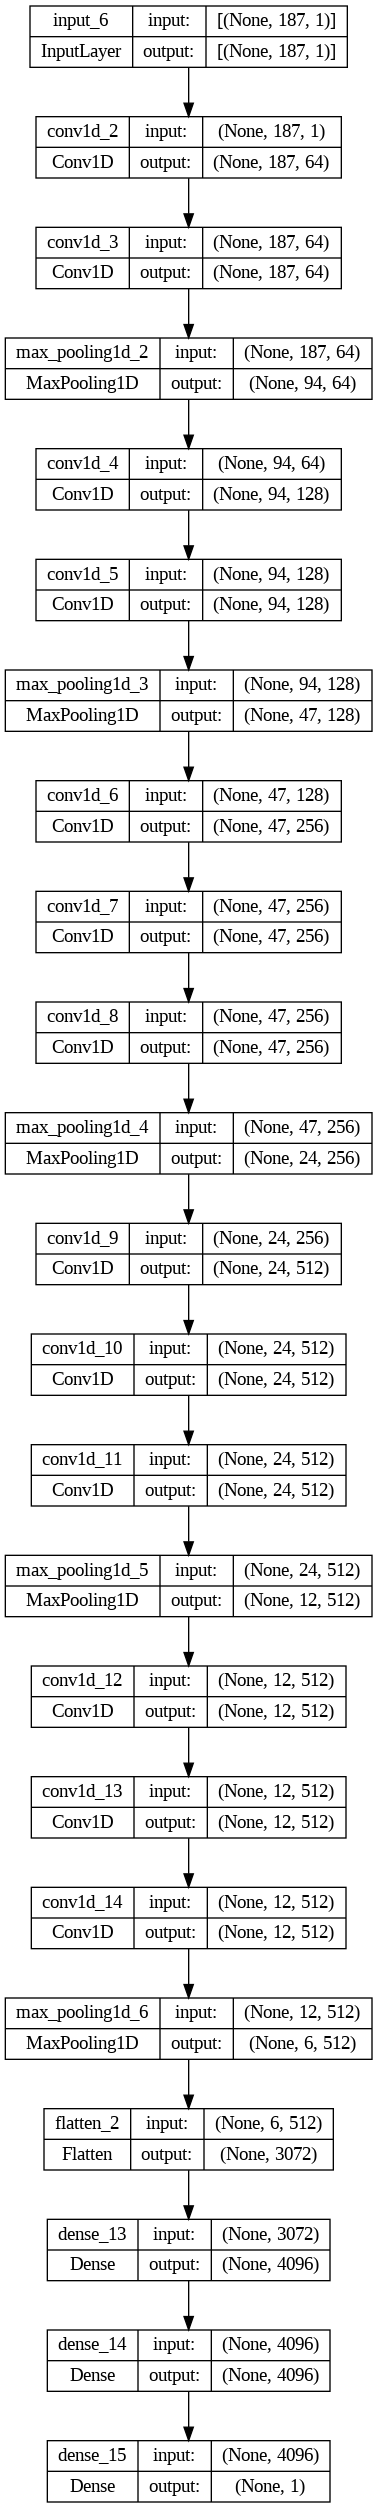

In [32]:
plot_model(vgg16_model, show_shapes=True, show_layer_names=True)

In [33]:
vgg16_model = create_vgg16_model()
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)

# vgg16_history = vgg16_model.fit(x=X_train, y=y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)

In [38]:
# TODO: Plot training process

In [39]:
# simple_CNN_model.save('simple_CNN_model')

## 5.4. ResNet

In [34]:
# https://www.kaggle.com/code/songrise/implementing-resnet-18-using-keras/notebook
# https://www.kaggle.com/code/aryarishabh/ecg-heartbeat-categorization-resnet#Resnet-model

def residual_block(X, num_filter, kernel_size, down_sample=False):

    X_shortcut = X

    if down_sample == False:
        X = Conv1D(filters=num_filter, kernel_size=kernel_size, strides=1, padding='same')(X)
    else:
        X = Conv1D(filters=num_filter, kernel_size=kernel_size, strides=2, padding='same')(X)
        X_shortcut = Conv1D(filters=num_filter, kernel_size=1, strides=2, padding='same')(X_shortcut)
        X_shortcut = BatchNormalization(axis=2)(X_shortcut)

    X = BatchNormalization(axis=2)(X)
    X = ReLU()(X)

    X = Conv1D(filters=num_filter, kernel_size=kernel_size, strides=1, padding='same')(X)
    X = BatchNormalization(axis=2)(X)

    X = Add()([X, X_shortcut])
    X = ReLU()(X)

    return X

In [35]:
def create_resnet18_model():
    input_layer = Input(shape =(187,1))
    # Conv1
    x = Conv1D(filters=64, kernel_size=7, strides=2, padding='same')(input_layer)
    # Conv2_x
    x = MaxPooling1D(pool_size =3, strides =2, padding ='same')(x)
    x = residual_block(x, num_filter=64, kernel_size=3, down_sample=False)
    x = residual_block(x, num_filter=64, kernel_size=3, down_sample=False)
    # Conv3_x
    x = residual_block(x, num_filter=128, kernel_size=3, down_sample=True)
    x = residual_block(x, num_filter=128, kernel_size=3, down_sample=False)
    # Conv4_x
    x = residual_block(x, num_filter=256, kernel_size=3, down_sample=True)
    x = residual_block(x, num_filter=256, kernel_size=3, down_sample=False)
    # Conv5_x
    x = residual_block(x, num_filter=512, kernel_size=3, down_sample=True)
    x = residual_block(x, num_filter=512, kernel_size=3, down_sample=False)
    # Classifier
    x = GlobalAveragePooling1D()(x)
    output_layer = Dense(1, activation="sigmoid")(x)
    return Model(inputs=input_layer, outputs=output_layer)

resnet18_model = create_resnet18_model()
resnet18_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 187, 1)]             0         []                            
                                                                                                  
 conv1d_28 (Conv1D)          (None, 94, 64)               512       ['input_8[0][0]']             
                                                                                                  
 max_pooling1d_12 (MaxPooli  (None, 47, 64)               0         ['conv1d_28[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_29 (Conv1D)          (None, 47, 64)               12352     ['max_pooling1d_12[0][0]

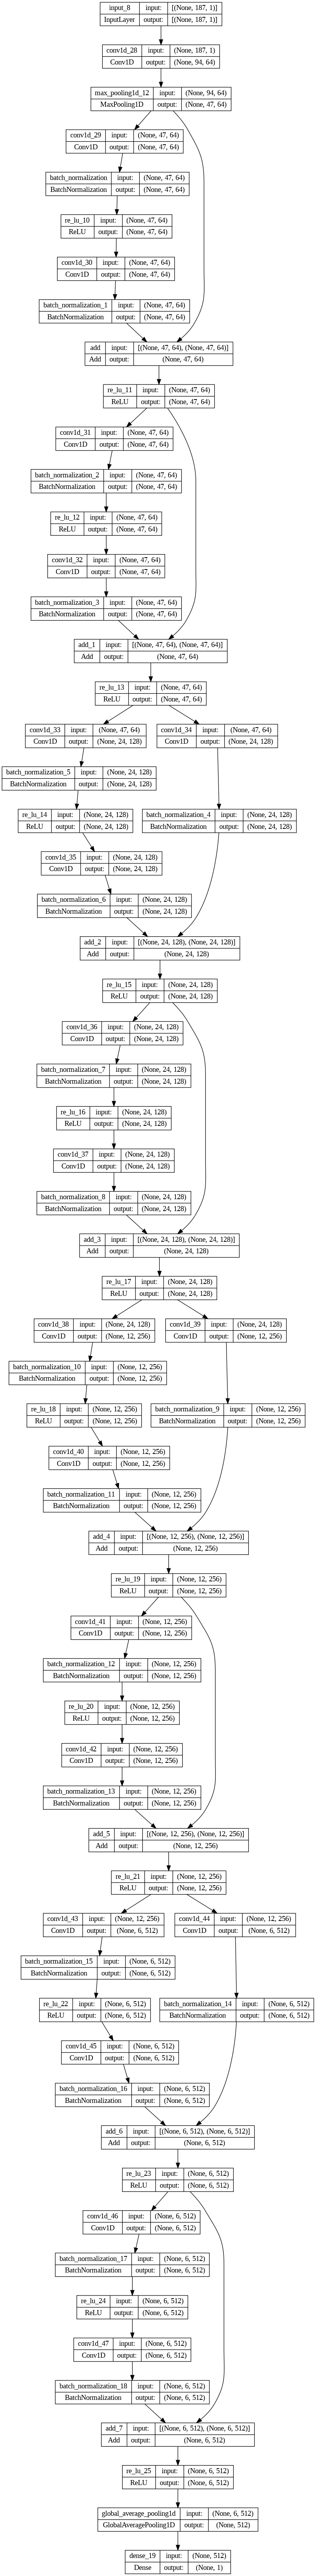

In [36]:
plot_model(resnet18_model, show_shapes=True, show_layer_names=True)

In [37]:
resnet18_model = create_resnet18_model()
resnet18_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)
# resnet18_history = resnet18_model.fit(x=X_train, y=y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)

In [40]:
# TODO: Plot training process

In [41]:
# resnet18_model.save("resnet18")

## 5.5. InceptionV1

In [42]:
def inception_module(x,filters_1x1,filters_3x3_reduce,filters_3x3, filters_5x5_reduce,filters_5x5,filters_pool_proj):
    # branch 1x1
    conv_1x1 = Conv1D(filters_1x1, kernel_size=1, padding="same", activation="relu")(x)
    # branch 3x3
    conv_3x3 = Conv1D(filters_3x3_reduce, kernel_size=1, padding="same", activation="relu")(x)
    conv_3x3 = Conv1D(filters_3x3, kernel_size=3, padding="same", activation="relu")(conv_3x3)
    # branch 5x5
    conv_5x5 = Conv1D(filters_5x5_reduce, kernel_size=1, padding="same", activation="relu")(x)
    conv_5x5 = Conv1D(filters_5x5, kernel_size=5, padding="same", activation="relu")(conv_5x5)
    # brance pool
    pool_proj = MaxPooling1D(pool_size = 3, strides=1, padding="same")(x)
    pool_proj = Conv1D(filters_pool_proj, kernel_size=1, padding="same", activation="relu")(pool_proj)
    # channel concat
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=2)

    return output


In [43]:
def create_inception_v1_model():
    # input
    input_layer = Input(shape=(187, 1))
    x = Conv1D(filters= 64, kernel_size= 7, padding="same", strides=2, activation="relu")(input_layer)
    x = MaxPooling1D(pool_size = 3, padding="same", strides= 2)(x)
    x = Conv1D(filters= 64, kernel_size= 1, padding="same", strides=1, activation="relu")(x)
    x = Conv1D(filters=192, kernel_size= 3, padding="same", strides=1, activation="relu")(x)
    x = MaxPooling1D(pool_size = 3, padding="same", strides= 2)(x)

    # Inception module 3a
    x = inception_module(x,filters_1x1=64,filters_3x3_reduce=96,filters_3x3=128,filters_5x5_reduce=16,filters_5x5=32,filters_pool_proj=32)

    # Inception module 3b
    x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128,filters_3x3=192,filters_5x5_reduce=32,filters_5x5=96,filters_pool_proj=64)

    # Max pool
    x = MaxPooling1D(pool_size = 3, padding="same", strides=2)(x)

    # Inception module 4a
    x = inception_module(x,filters_1x1=192,filters_3x3_reduce=96,filters_3x3=208,filters_5x5_reduce=16,filters_5x5=48,filters_pool_proj=64)

    # output 1
    x1 = AveragePooling1D(pool_size = 5, strides=3)(x)
    x1 = Conv1D(filters=128, kernel_size=1, padding="same", activation="relu")(x1)
    x1 = Flatten()(x1)
    x1 = Dense(1024, activation="relu")(x1)
    x1 = Dropout(0.7)(x1)
    x1 = Dense(1, activation='sigmoid')(x1)

    # Inception module 4b
    x = inception_module(x,filters_1x1=160,filters_3x3_reduce=112, filters_3x3=224,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64)

    # Inception module 4c
    x = inception_module(x,filters_1x1=128,filters_3x3_reduce=128, filters_3x3=256,filters_5x5_reduce=24,filters_5x5=64,filters_pool_proj=64)

    # Inception module 4d
    x = inception_module(x,filters_1x1=112,filters_3x3_reduce=144, filters_3x3=288,filters_5x5_reduce=32,filters_5x5=64,filters_pool_proj=64)

    # output 2
    x2 = AveragePooling1D(pool_size = 5, strides=3)(x)
    x2 = Conv1D(filters=128, kernel_size=1, padding="same", activation="relu")(x2)
    x2 = Flatten()(x2)
    x2 = Dense(1024, activation="relu")(x2)
    x2 = Dropout(0.7)(x2)
    x2 = Dense(1, activation='sigmoid')(x2)

    # Inception module 4e
    x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128)

    # Max pool
    x = MaxPooling1D(pool_size = 3, padding="same", strides=2)(x)

    # Inception module 5a
    x = inception_module(x,filters_1x1=256,filters_3x3_reduce=160, filters_3x3=320,filters_5x5_reduce=32,filters_5x5=128, filters_pool_proj=128)

    # Inception module 5b
    x = inception_module(x, filters_1x1=384,filters_3x3_reduce=192, filters_3x3=384,filters_5x5_reduce=48,filters_5x5=128, filters_pool_proj=128)

    # output 3
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=[x,x1,x2])
    return model

from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten
inception_v1_model = create_inception_v1_model()
inception_v1_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 187, 1)]             0         []                            
                                                                                                  
 conv1d_68 (Conv1D)          (None, 94, 64)               512       ['input_10[0][0]']            
                                                                                                  
 max_pooling1d_14 (MaxPooli  (None, 47, 64)               0         ['conv1d_68[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_69 (Conv1D)          (None, 47, 64)               4160      ['max_pooling1d_14[0][0]

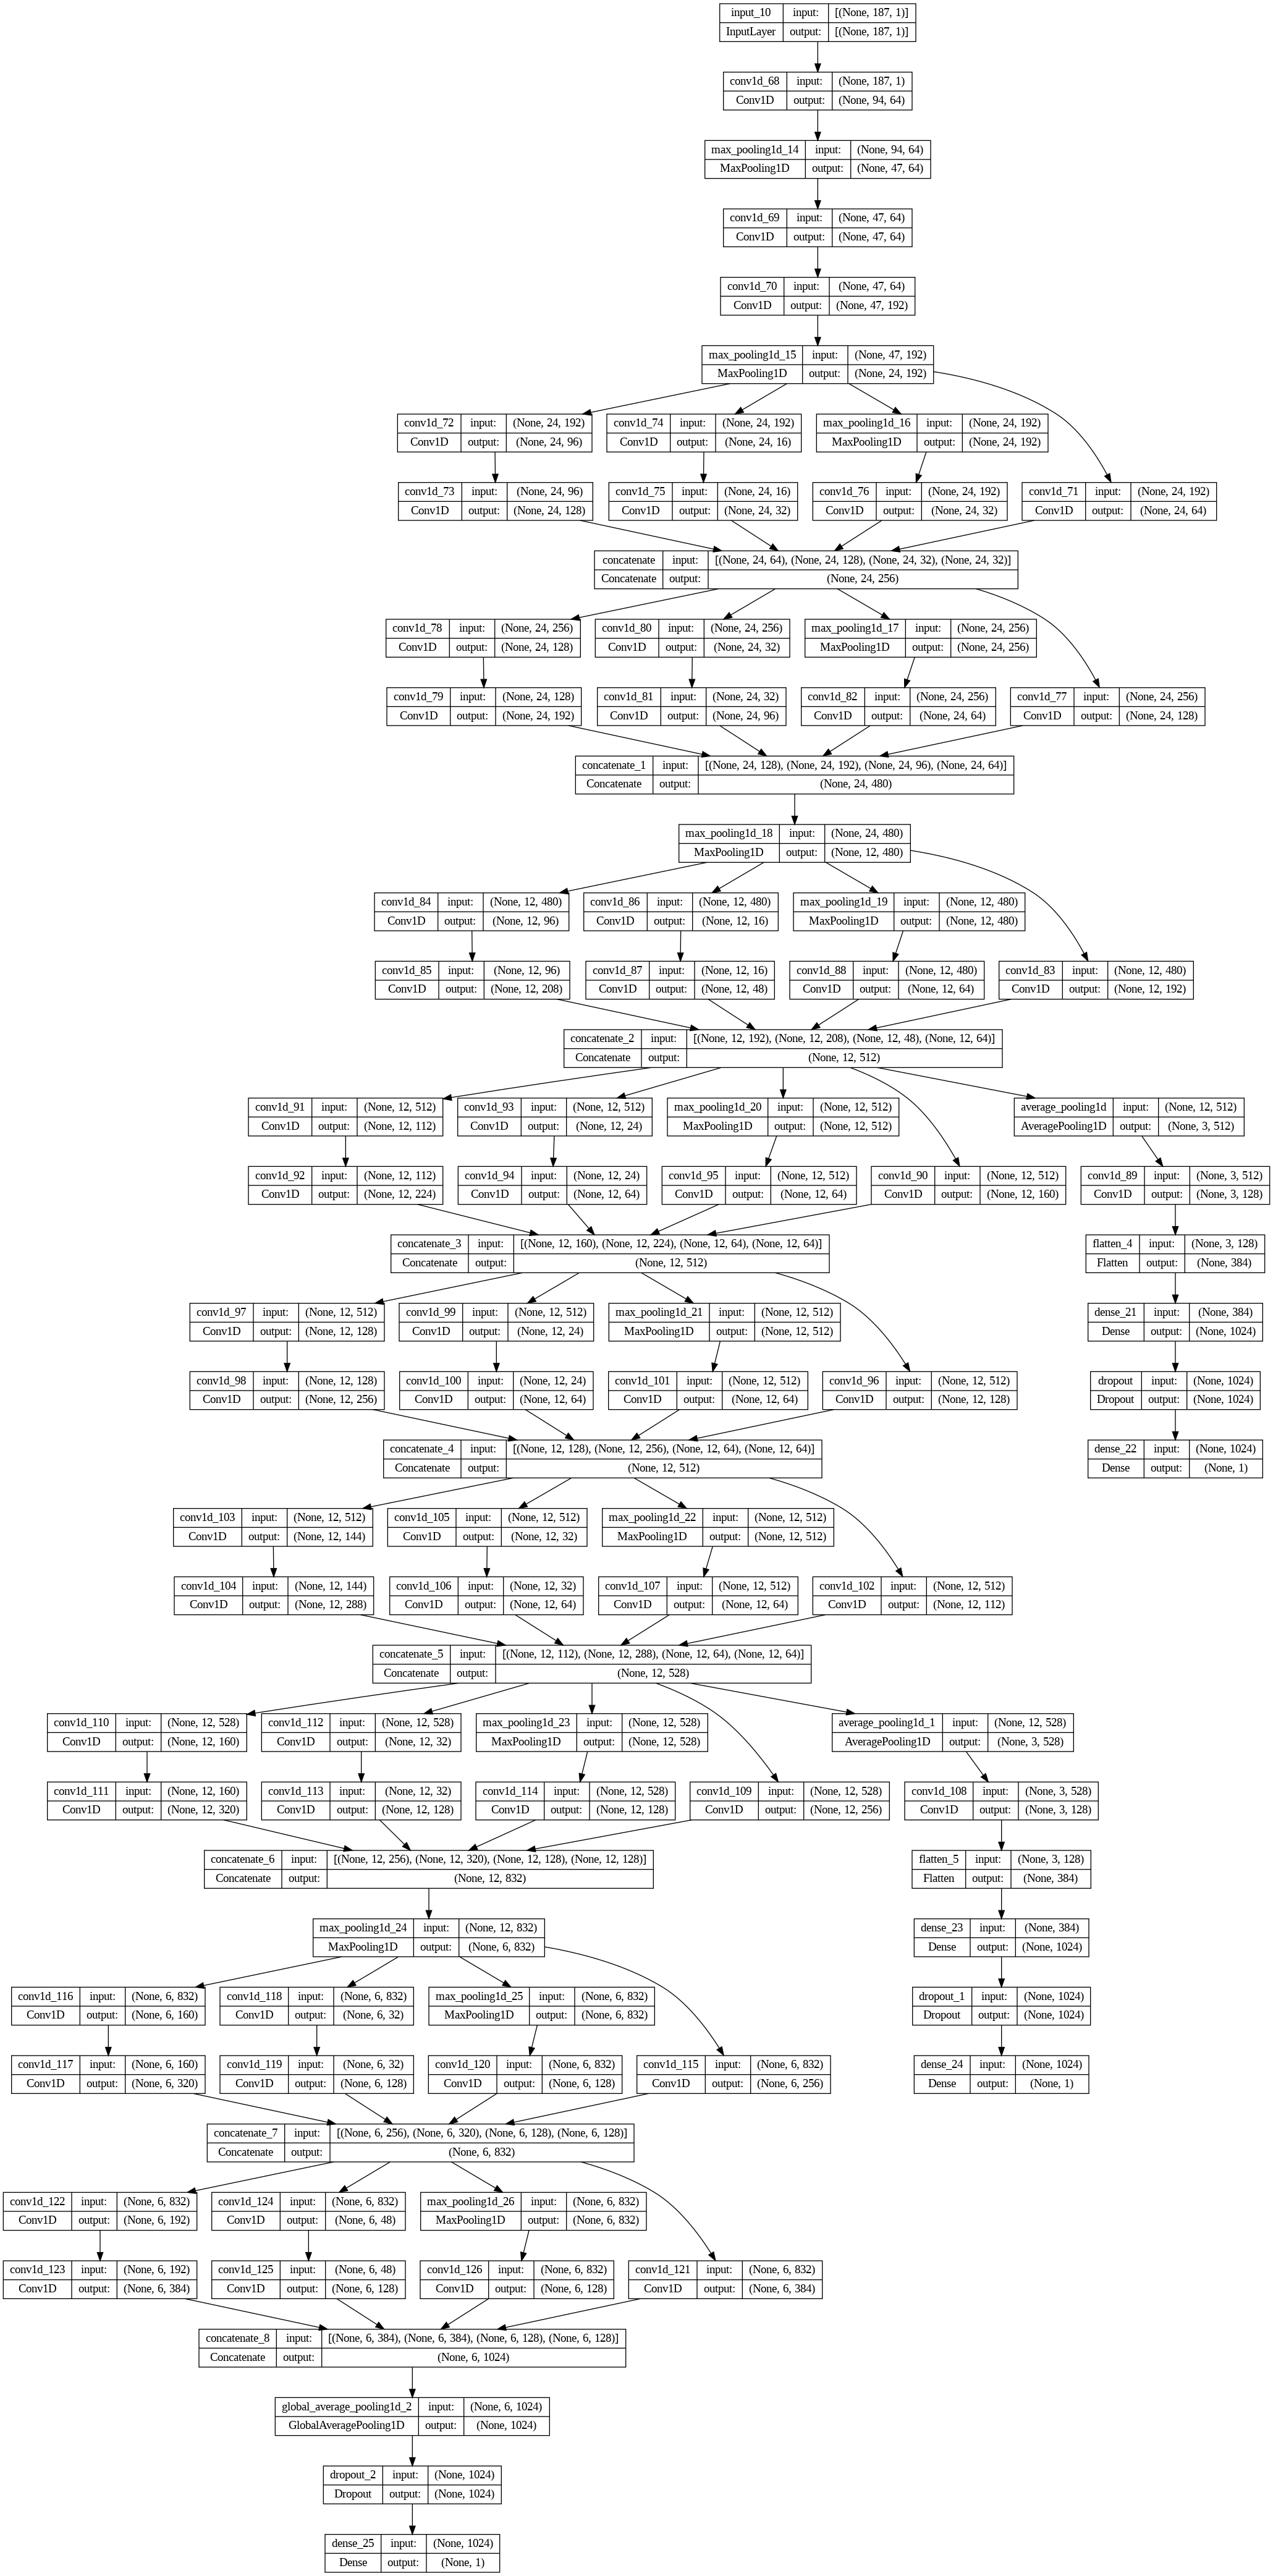

In [44]:
plot_model(inception_v1_model, show_shapes=True, show_layer_names=True)

In [ ]:
inception_v1_model = create_inception_v1_model()
inception_v1_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=[tf.keras.losses.BinaryCrossentropy(),tf.keras.losses.BinaryCrossentropy(),tf.keras.losses.BinaryCrossentropy()], loss_weights=[1, 0.3, 0.3],
              metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC()]
)
# inception_v1_history= inception_v1_model.fit(x=X_train, y=y_train, batch_size=1000, epochs=10, verbose=1, validation_data=(X_test, y_test), shuffle=True)

In [ ]:
# TODO: Plot training process

In [ ]:
# inception_v1_history.save("resnet18")